<a href="https://colab.research.google.com/github/Jiaweihu08/Real-or-Not---Text-Classification/blob/master/Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Loading Libraries**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import FreqDist
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub

import string
import re

## **Loading data**

In [0]:
# Files mounted from Drive
train_path = "/content/drive/My Drive/Colab Notebooks/NLP/Real or Not/train.csv"
test_path = "/content/drive/My Drive/Colab Notebooks/NLP/Real or Not/test.csv"

def load_data(path=train_path):
    return pd.read_csv(path)

df = load_data()
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## **Exploratory Data Analysis(EDA)**

**EDA content:**

    1. Check weather the dataset is balanced i.e. the same number of instances for each category.

    2. keyword and location analysis: check the most frequent keyword and locations for each case and see if there's a strong overlap. How sparse are they?(The amount of NAN).
    
    3. text analysis, for each category:
        a. most common words
        b. average text length
        c. average word length
        e. hashtag analysis: what are the most frequent hashtags used for each category

        

#### **Balanced dataset?**

If the number of instances is the similar for all categories then yes.
Otherwise consider using **Precision** or **Recall** instead of accuracy as metrics.

**Precision** tells you that, among all the positive predictions, what percentage of them were correct.

**Recall** statands for the percentage of the positive instances that were correctly predicted. 

Use Precision if want to minimize **false alarms**, and use Recall if you want to minimized **missed opportunities**.

Say that we were to used tweets as a predictor for disaster and we want to act as quick as possible when a disaster is being 'reported' via twitter. We would want to used Recall as the metrics cause it minimizes the chance of a positive case being missclassified.

On the other hand, if we want to optimized the usage of our resources, Precision should be applied since it makes sure that false positives are as little as possible.

Precision/Recall are trad-offs since if one increases the other one necessarily deseases. If we want to balance them out we should use **F1 score**.

- Columns in the data frame: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

- Number of total instances: 7613
- Number of 'positive' tweets: 4342 --> 57%
- Number of 'disaster' tweets: 3271 --> 43%


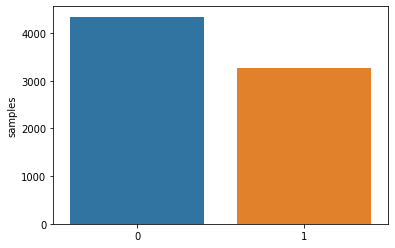

In [0]:
pos = len(df[df['target'] == 0])
neg = len(df[df['target'] == 1])
total = len(df)

print("- Columns in the data frame: {}\n".format(df.columns))
print("- Number of total instances: {}".format(total))
print("- Number of 'positive' tweets: {} --> {:.0f}%".format(pos, pos/total*100))
print("- Number of 'disaster' tweets: {} --> {:.0f}%".format(neg, neg/total*100))

x = df.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')
plt.show()

#### **Keyword and Location**

For both Keyword and Location, check **sparsity**. If good, proceed analysis to see the amount of overlap.

In [0]:
total_kw = len(df[df['keyword'].isna()])
total_lc = len(df[df['location'].isna()])

unique_kw = len(set(df.keyword.values)) - 1
unique_lc = len(set(df.location.values)) - 1

print("Number of instances with keywords: {} --> {:.0f}%".format(total-num_nan_kw,
                                                                 (total-num_nan_kw)/total*100))
print("     {} of which are unique.".format(unique_kw))

print("Number of instances with locations: {} -- > {:.0f}%".format(total-num_nan_lc,
                                                                   (total-num_nan_lc)/total*100))
print("     {} of which are unique.".format(unique_lc))
print("\nLocation is too sparse to be used!")

Number of instances with keywords: 7552 --> 99%
     221 of which are unique.
Number of instances with locations: 5080 -- > 67%
     3341 of which are unique.

Location is too sparse to be used!


In [0]:
total_kw_counts = dict(df['keyword'].value_counts())
positive_kw_counts = dict(df[df['target'] == 0].keyword.value_counts())
disaster_kw_counts = dict(df[df['target'] == 1].keyword.value_counts())

for kw, _ in sorted(total_kw_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print("Keyword: {}".format(kw))
    print("     - Counts in 'Positive' tweets: {}".format(positive_kw_counts.get(kw, None)))
    print("     - Counts in 'Disaster' tweets: {}".format(disaster_kw_counts.get(kw, None)))
    print()
    
print("\nThe most frequent keywords are used in both categories!")

Keyword: fatalities
     - Counts in 'Positive' tweets: 19
     - Counts in 'Disaster' tweets: 26

Keyword: armageddon
     - Counts in 'Positive' tweets: 37
     - Counts in 'Disaster' tweets: 5

Keyword: deluge
     - Counts in 'Positive' tweets: 36
     - Counts in 'Disaster' tweets: 6

Keyword: sinking
     - Counts in 'Positive' tweets: 33
     - Counts in 'Disaster' tweets: 8

Keyword: body%20bags
     - Counts in 'Positive' tweets: 40
     - Counts in 'Disaster' tweets: 1

Keyword: damage
     - Counts in 'Positive' tweets: 22
     - Counts in 'Disaster' tweets: 19

Keyword: harm
     - Counts in 'Positive' tweets: 37
     - Counts in 'Disaster' tweets: 4

Keyword: fear
     - Counts in 'Positive' tweets: 35
     - Counts in 'Disaster' tweets: 5

Keyword: outbreak
     - Counts in 'Positive' tweets: 1
     - Counts in 'Disaster' tweets: 39

Keyword: windstorm
     - Counts in 'Positive' tweets: 24
     - Counts in 'Disaster' tweets: 16


The most frequent keywords are used in bo

#### **Text Analysis**

Most common words:


Most Common Words in Positive Tweets:
       Frequency
Word            
like         253
im           243
amp          192
new          168
get          163
dont         141
one          128
body         112
via           99
would         97

Most Common Words in Disaster Tweets:
            Frequency
Word                 
fire              178
news              136
via               121
disaster          117
california        111
suicide           110
police            107
amp               106
people            105
killed             93


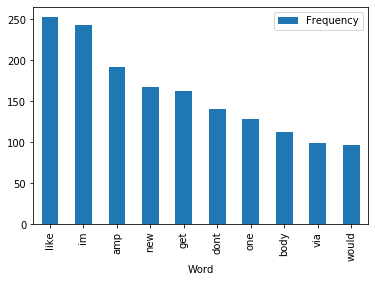

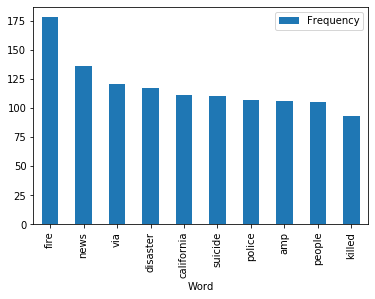

In [0]:
# Let's find the most common words in each category, excluding
# punctuations and stop words.

table = str.maketrans(' ', ' ', string.punctuation)
stop = set(stopwords.words('english') + ['http', 'https'])

def most_common(target_, field='text', stop=stop, remove_punc=True, cloud=False):
    title = 'Disaster' if target_ == 1 else 'Positive'
    print("\nMost Common Words in {} Tweets:".format(title))

    text = df[df['target'] == target_][field].str.lower().str.cat(sep=' ')
    if remove_punc:
        text = text.translate(table)
    words = word_tokenize(text)
    word_dist = FreqDist(w for w in words if w not in stop)

    result = pd.DataFrame(word_dist.most_common(10), columns=['Word', 'Frequency']).set_index('Word')
    print(result)
    if cloud:
        wc = WordCloud(background_color='white')
        wc.generate(text)

        plt.axis('off')
        plt.imshow(wc)
        plt.show()
    else:
        result.plot.bar()

most_common(0)
most_common(1)

Text and Word Distribution:

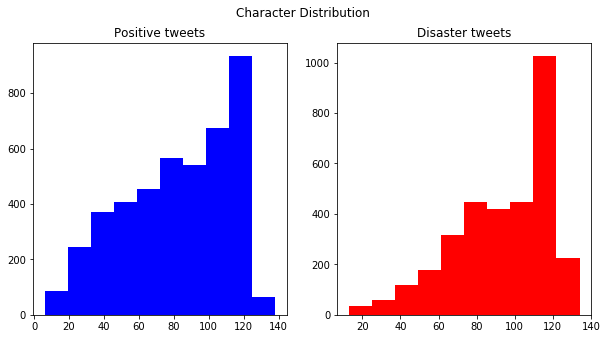

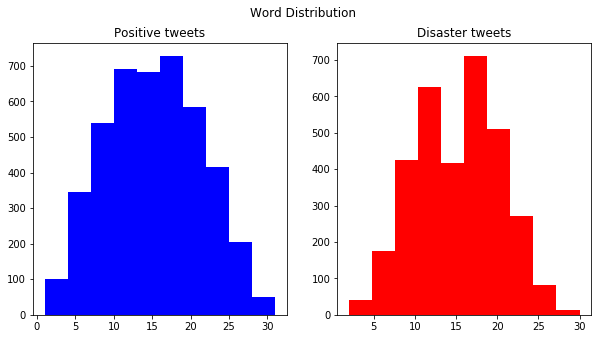

In [0]:
def plot_hist(_dist, _header):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(_dist(0), color='blue')
    ax1.set_title('Positive tweets')

    ax2.hist(_dist(1), color='red')
    ax2.set_title('Disaster tweets')

    fig.suptitle(_header)
    plt.show()
    plt.close()

def char_dist(_target):
    return df[df['target'] == _target]['text'].str.replace(' ', '').str.len()

def word_dist(_target):
    return df[df['target'] == _target]['text'].str.split().map(lambda x: len(x))

plot_hist(char_dist, "Character Distribution")
plot_hist(word_dist, "Word Distribution")

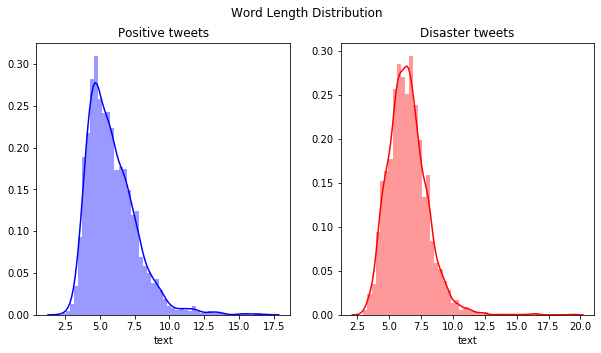

In [0]:
pos_avg_len = df[df['target'] == 0]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))
dis_avg_len = df[df['target'] == 1]['text'].str.split().map(lambda x: np.mean([len(i) for i in x]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(pos_avg_len, ax=ax1, color='blue')
ax1.set_title("Positive tweets")
sns.distplot(dis_avg_len, ax=ax2, color='red')
ax2.set_title("Disaster tweets")

fig.suptitle("Word Length Distribution")
plt.show()
plt.close()

Hashtag Analysis:

    1. Add a hashtag column to the dataset
    2. Find the top 10 most common hashtags in both categories


Most Common Words in Positive Tweets:
            Frequency
Word                 
nowplaying         21
news               20
hot                18
prebreak           17
best               17
gbbo               14
jobs               14
islam              14
job                12
hiring             10

Most Common Words in Disaster Tweets:
            Frequency
Word                 
news               56
hiroshima          22
earthquake         19
hot                13
prebreak           13
best               13
japan              11
india              10
yyc                10
breaking            9


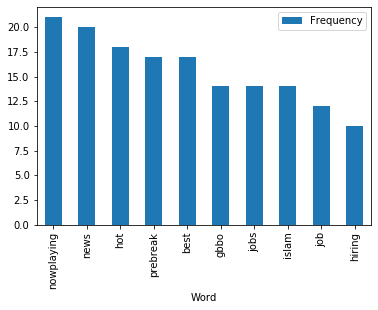

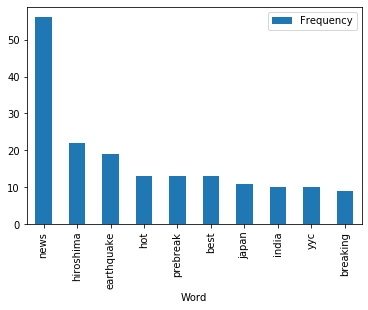

In [0]:
def find_hash(tweet):
    return ' ,'.join(re.findall(r'#\w+', tweet)) or None

df['hashtags'] = df['text'].map(lambda tweet: find_hash(tweet))
df.head()

hash_stop = set(['#', ','])
most_common(0, field='hashtags', stop=hash_stop, remove_punc=False)
most_common(1, field='hashtags', stop=hash_stop, remove_punc=False)



## **Data Cleaning**

    1. Lowercasing
    2. Remove url
    3. Remove html tags
    4. Remove punctuations
    5. Remove emojis
    6. Stemming/Lemmatization

In [0]:
def clean_data(df=df, rm_stop=False, lemma=False):
    # lowercasing
    df['text'] = df['text'].str.lower()

    # remove url
    def remove_url(tweet):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(' ', tweet)
    df['text'] = df['text'].map(lambda tweet: remove_url(tweet))

    # remove html tags
    def remove_html(tweet):
        pattern = re.compile(r'<\.*?>')
        return pattern.sub(' ', tweet)
    df['text'] = df['text'].map(lambda tweet: remove_html(tweet))

    # remove punctuations
    table = str.maketrans(' ', ' ', string.punctuation)
    def remove_punc(tweet):
        return tweet.translate(table)
    df['text'] = df['text'].map(lambda tweet: remove_punc(tweet))

    # Removing emojis
    # Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    def remove_emoji(tweet):
        emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', tweet)
    df['text'] = df['text'].map(lambda tweet: remove_emoji(tweet))

    # Remove stopwords
    def remove_stop(tweet):
        stop = stopwords.words('english')
        return ' '.join([word for word in tweet.split() if word not in stop])
    if rm_stop:
        df['text'] = df['text'].map(lambda tweet: remove_stop(tweet))

    # Lemmatizing
    if lemma:
        def get_wordnet_pos(word):
            """Map POS tag to first character lemmatize() accepts"""
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)

        lemmatizer = WordNetLemmatizer()
        def lemmatize_tweet(tweet):
            words = word_tokenize(tweet)
            return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
        df['text'] = df['text'].map(lambda tweet: lemmatize_tweet(tweet))

    return df

In [0]:
df.head()

,id,keyword,location,text,target,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,#earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,None
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,None
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,#wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"#Alaska ,#wildfires"


In [0]:
df = clean_data()
df[['text']].head()

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,13000 people receive wildfires evacuation orde...
4,just got sent this photo from ruby alaska as s...


## **Modelling**

#### **Model Util**

In [0]:
from sklearn.model_selection import train_test_split
def get_train_test_data(rm_stop=False, lemma=False):
    df = load_data()
    df = clean_data(rm_stop=rm_stop, lemma=lemma)

    X_train, X_test, y_train, y_test = train_test_split(df.text, df.target, test_size=750, random_state=42)

    print("{} instances for training, {} for validation".format(len(X_train), len(X_test)))

    return X_train, y_train, X_test, y_test

#### **Baseline model**

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

baseline_pipe = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())
])

X_train, y_train, X_test, y_test = get_train_test_data(rm_stop=True, lemma=True)

baseline_pipe.fit(X_train, y_train)
y_pred = baseline_pipe.predict(X_test)

# print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       574
           1       0.80      0.65      0.72       426

    accuracy                           0.78      1000
   macro avg       0.79      0.77      0.77      1000
weighted avg       0.79      0.78      0.78      1000

0.783


#### **Gradient Boosting**

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

X_train, y_train, X_test, y_test = get_train_test_data()

gb_clf = Pipeline([
                   ('tfidf', TfidfVectorizer()),
                   ('gb_clf', GradientBoostingClassifier(n_estimators=300))
])

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

In [0]:
#XGBoost
import xgboost

xgbclf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer()),
                        ('xgb_clf', xgboost.XGBClassifier(n_estimators=300))
])

xgbclf_pipe.fit(X_train, y_train)
y_pred = xgbclf_pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))

#### **RNN**

In [0]:
X_train, y_train, X_test, y_test = get_train_test_data()

word_counts = X_train.map(lambda x: len(word_tokenize(x)))
print("\nThe max number of words in all training instances: {}".format(max(word_counts)))

words = word_tokenize(X_train.str.cat(sep=' '))
unique_words = len(set(words))
print("The number of unique words in all training instances: {}\n".format(unique_words))

oov_words = 2000
num_words = 10000
max_len = max(word_counts) + 5
emb_dim = 50
batch_size = 32
epochs = 10

def get_train_val_data():
    df = load_data()
    df = clean_data()

    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_words)
    tokenizer.fit_on_texts(X_train)

    seq = tokenizer.texts_to_sequences(df.text)
    seq = pad_sequences(seq, maxlen=max_len, padding='post')
    Y = np.expand_dims(df.target.values, -1)

    return seq, Y, tokenizer

def get_rnn_model():
    model = keras.models.Sequential([
                                     Embedding(input_dim=num_words+oov_words,
                                               output_dim=emb_dim,
                                               input_shape=[None]),
                                     LSTM(64),
                                     Dense(256, activation='relu'),
                                     Dropout(0.5),
                                     Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

X, Y, tok = get_train_val_data()
model = get_rnn_model()

history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

# def plot_graphs(history, string):
#     plt.plot(history.history[string])
#     plt.plot(history.history['val_'+string], '')
#     plt.xlabel('Epochs')
#     plt.ylabel(string)
#     plt.legend([string, 'val_'+string])
#     plt.show()

# plot_graphs(history, 'accuracy')
# plot_graphs(history, 'loss')

6863 instances for training, 750 for validation

The max number of words in all training instances: 25
The number of unique words in all training instances: 14725

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 50)          600000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 646,337
Trainable params: 646,337
Non-trainable params: 0
________________

#### **BERT TfHub**

Creating the model for text classification:

The BERT layer takes 3 input arguments:

    1. input_word_ids: sequence of word tokens
    2. input_mask: masking the paddings
    3. segment_ids: used to identify either of the input sentences

The BERT output consists of 

    1. pooled_output, a condensed sequence representation. And
    2. sequence_output, the entire encoding of the input.

We take the sequence output and pass it to a single-unit dense layer for classification.

BERT is pre-trained on a large text corpus and it has generated its own vocabulary. We use its own tokenizer to tokenize our sentences.

Note: Sentences always start with '[CLS]' token and it's embedding is used as a sentence-level representation(sequence_output[:, 0, :]).

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece

import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

def get_bert_layer_tokenizer():
    # Creating the bert layer
    # module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
    module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
    bert_layer = hub.KerasLayer(module_url, trainable=True)

    # Instantiating BERT Tokenizer
    vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
    tokenizer = FullTokenizer(vocab_file, do_lower_case)
    return bert_layer, tokenizer

def get_tokens(tweet, tokenizer):
    tokens = tokenizer.tokenize(tweet)
    return ["[CLS]"] + tokens + ["[SEP]"]

def get_ids(tokens, tokenizer, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length - len(token_ids))
    
    return input_ids

def get_masks(tokens, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    return [1] * len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length=160):
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length")

    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == '[SEP]':
            current_segment_id = 1

    return segments + [0] * (max_seq_length - len(tokens))

def bert_encode(X, tokenizer):
    token_ids = []
    token_masks= []
    token_segments = []

    for text in X:
        tokens = get_tokens(text, tokenizer)

        token_id = get_ids(tokens, tokenizer)
        token_mask = get_masks(tokens)
        token_segment = get_segments(tokens)

        token_ids.append(token_id)
        token_masks.append(token_mask)
        token_segments.append(token_segment)

    return np.array(token_ids), np.array(token_masks), np.array(token_segments)

def bert_model(bert_layer, max_seq_length = 512):
    input_word_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    input_mask = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
    segment_ids = keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    # bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
    #                             trainable=True)
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    kernel_size = 5
    filters = 64
    pool_size = 4
    
    x = keras.layers.Dropout(0.1)(sequence_output)
    x = keras.layers.Conv1D(filters,
                            kernel_size,
                            padding='valid',
                            activation='relu',
                            strides=1)(x)
    x = keras.layers.MaxPooling1D(pool_size=pool_size)(x)
    x = keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
    out = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    opt = keras.optimizers.Adam(lr=1e-5)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

batch_size = 16
epochs = 20

df = load_data()
df = clean_data()
X = df['text'].values
Y = np.expand_dim(df['target'].values, -1)

bert_layer, tokenizer = get_bert_layer_tokenizer()
X = bert_encode(X, tokenizer)

bert = bert_model(bert_layer)
bert_summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=4,
    mode='max',
    restore_best_weights=True)

history = bert.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

#### **SuperLearner Ensemble**

In [0]:
!pip install bert-for-tf2
!pip install sentencepiece
import bert
FullTokenizer = bert.bert_tokenization.FullTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy


class ToDense(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

def get_ensemble():
    tfidf_vectorizer = TfidfVectorizer(
        # preprocessor=lambda x: x,
        # tokenizer=lambda x: x,
        # token_pattern=None
    )

    lr_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('lr', LogisticRegression())])
    tree_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('dt', DecisionTreeClassifier())])
    gaus_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('to_dense', ToDense()), ('gaus', GaussianNB())])
    kn_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('kn', KNeighborsClassifier())])
    svm_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('svm', SVC(gamma='scale', probability=True))])
    bag_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('bag', BaggingClassifier(n_estimators=10))])
    rf_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('rf', RandomForestClassifier(n_estimators=10))])
    et_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('et', ExtraTreesClassifier(n_estimatos=10))])
    ada_pipe = Pipeline([('tfidf', tfidf_vectorizer), ('ada', AdaBoostClassifier(n_estimators=10))])
    gb_pipe = Pipeline([('tfidf', TfidfVectorizer()),('gb', GradientBoostingClassifier(n_estimators=100))])
    # bert_pipe = Pipeline([('bert_vec' BertVectorizer(), ('bert_clf', BertClassifier(num_classes=2)))])

    bert_layer, tokenizer = get_bert_layer_tokenizer()
    bert_model = bert_model(bert_layer)
    bert_model.summary()

    ensemble = list()
    # ensemble.append(bert_pipe)
    ensemble.append(bert_model)
    ensemble.append(lr_pipe)
    ensemble.append(tree_pipe)
    ensemble.append(gaus_pipe)
    ensemble.append(kn_pipe)
    ensemble.append(svm_pipe)
    ensemble.append(bag_pipe)
    ensemble.append(rf_pipe)
    ensemble.append(et_pipe)
    ensemble.append(ada_pipe)
    ensemble.append(gb_pipe)
    
    return ensemble

def get_meta_data(ensemble, X, y):
    kfold = KFold(n_splits=5, shuffle=True)
    meta_X, meta_y = list(), list()
    
    for train_ids, test_ids in kfold.split(X):
        yhat = list()
        
        train_X, train_y = X[train_ids], y[train_ids]
        test_X, test_y = X[test_ids], test_y[test_ids]
        
        meta_y.extend(test_y)
        
        for num, model in enumerate(ensembel):
            if num == 0:
                train_X = bert_encode(train_X)
                test_X = bert_encode(test_X)
                
                early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', 
                    verbose=1,
                    patience=4,
                    mode='max',
                    restore_best_weights=True)
                
                model.fit(train_X, train_y, batch_size=16, epochs=10,
                          validation_split=0.25, callbacks=[early_stopping])
                preds = model.predict(test_X)
                _y = list()
                for t in preds:
                    one_prob = t[0]
                    zero_prob = 1 - one_prob
                    _y.append([zero_prob, one_prob])
                preds = np.asarray(_y)
            else:
                model.fit(train_X, train_y)
                preds = model.predict_proba(test_X)
            
            yhat.append(preds)

        meta_X.append(np.hstack(yhat))
    
    return np.vstack(meta_X), np.asarray(meta_y)

def fit_ensemble(ensemble, X, y):
    for num, model in enumerate(ensemble):
        if num == 0:
            X = bert_encode(X)
            early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy', 
                    verbose=1,
                    patience=4,
                    mode='max',
                    restore_best_weights=True)
                
            model.fit(X, y, batch_size=16, epochs=10,
                      validation_split=0.10, callbacks=[early_stopping])
        else:
            model.fit(X, y)
    
def fit_blender(meta_X, meta_y):
    blender = ExtraTreesClassifier(n_estimators=30)
    blender.fit(meta_X, meta_y)
    return blender

def ensemble_prediction(ensemble, blender, X):
    meta_X = list()
    for num, model in enumerate(ensemble):
        if num == 0:
            preds = model.predict(X)
            _y = list()
            for t in preds:
                one_prob = t[0]
                zero_prob = 1 - one_prob
                _y.append([zero_prob, one_prob])
            preds = np.asarray(_y)
        else:
            preds = model.predict_proba(X)
        meta_X.append(preds)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_x)

In [0]:
X_train, X_test, y_train, y_test = get_train_test_data()

ensemble = get_ensemble()

meta_X, meta_y = get_meta_data(ensemble, X_train, y_train)
print('Meta data: ', meta_X.shape)

fit_ensemble(ensemble, X_train, y_train)

blender = fit_blender(meta_X, meta_y)

test_preds = ensemble_prediction(ensemble, blender, X_test)

print(accuracy_score(y_test, test_preds))